In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense
import matplotlib.pyplot as plt
import seaborn as snc

Using TensorFlow backend.


In [79]:
# load a single file as a numpy array
df = pd.read_csv('../Data/WISDM_ar_v1.1_raw.txt',header=None,sep=",",error_bad_lines=False,names=["user-id","Activity","timestamp","X","Y","Z"])
df.head()

,user-id,Activity,timestamp,X,Y,Z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;


In [80]:
df['Z'].replace(regex=True, inplace=True,to_replace=r';',value=r'')
df['Z'] = df['Z'].astype(np.float64)

In [81]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

In [82]:
mean_val = df_test.iloc[:,-3:].mean(axis=0)

In [83]:
df_train.isnull().count()

user-id      834781
Activity     834781
timestamp    834781
X            834781
Y            834781
Z            834781
dtype: int64

In [84]:
df_train.dropna()

,user-id,Activity,timestamp,X,Y,Z
8489,17,Walking,57869902574000,0.572055,9.806650,-0.531194
8490,17,Walking,57870012316000,-0.000000,10.188020,-0.572055
8491,17,Walking,57870122301000,-0.231546,9.847511,-0.694638
8492,17,Walking,57870222246000,0.149824,10.079058,-0.503953
8493,17,Walking,57870332292000,0.149824,10.147159,-0.612916
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [85]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(df_train[["X","Y","Z"]])

# # normalization
# tmp = df_train[["X","Y","Z"]].copy()
# mu = tmp.mean()
# sigma = [np.std(tmp[col]) for col in ["X","Y","Z"]]
# tmp
# x_train = (tmp-mu)/sigma

In [88]:
from sklearn.preprocessing import LabelEncoder 
le = LabelEncoder()
y_train = le.fit_transform(df_train["Activity"])
y_train

array([5, 5, 5, ..., 2, 2, 2])

In [89]:
from scipy import stats
def create_segments_and_labels(x,y, time_steps=80, step=40, label_name=""):
    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    print("length",len(x))
    for i in range(0, len(x) - time_steps, step):
        xs = x[i: i + time_steps,0]
        ys = x[i: i + time_steps,1]
        zs = x[i: i + time_steps,2]
        # Retrieve the most often used label in this segment
        label = stats.mode(y[i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)
    print(segments)
    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels
x_train,y_train = create_segments_and_labels(x_train,y_train)

length 834781


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [90]:
x_train[0].shape

(80, 3)

In [91]:
num_classes = le.classes_.size
y_train = np_utils.to_categorical(y_train, num_classes) # alternative to one hot encoding

In [92]:
x_train.shape,y_train.shape

((20868, 80, 3), (20868, 6))

In [93]:
no_timeStamp_in_row,no_features = x_train.shape[1],x_train.shape[2]
no_output = y_train.shape[1] 

In [126]:
help(Reshape)

Help on class Reshape in module keras.layers.core:

class Reshape(keras.engine.base_layer.Layer)
 |  Reshape(target_shape, **kwargs)
 |  
 |  Reshapes an output to a certain shape.
 |  
 |  # Arguments
 |      target_shape: target shape. Tuple of integers.
 |          Does not include the batch axis.
 |  
 |  # Input shape
 |      Arbitrary, although all dimensions in the input shaped must be fixed.
 |      Use the keyword argument `input_shape`
 |      (tuple of integers, does not include the batch axis)
 |      when using this layer as the first layer in a model.
 |  
 |  # Output shape
 |      `(batch_size,) + target_shape`
 |  
 |  # Example
 |  
 |  ```python
 |      # as first layer in a Sequential model
 |      model = Sequential()
 |      model.add(Reshape((3, 4), input_shape=(12,)))
 |      # now: model.output_shape == (None, 3, 4)
 |      # note: `None` is the batch dimension
 |  
 |      # as intermediate layer in a Sequential model
 |      model.add(Reshape((6, 2)))
 |     

# Model 1 - 1 Convolution layer and 1 Dense Layer

In [127]:
import keras
from keras import regularizers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv1D,MaxPooling1D,Flatten,Dense,GlobalAveragePooling1D,Reshape

model = Sequential()
model.add(Reshape((80,3),input_shape=(no_timeStamp_in_row,no_features)))
model.add(Conv1D(100,10,activation='relu',input_shape=(80,3)))
model.add(MaxPooling1D(3))
model.add(Conv1D(100,10,activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Flatten())
model.add(Dense(10,activation='relu'))
model.add(Dense(no_output,activation='softmax'))
opt = optimizers.Adam(lr = 1e-04) 
model.compile(optimizer=opt,loss = 'categorical_crossentropy',metrics=['accuracy'])

# model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

ValueError: Input 0 is incompatible with layer flatten_17: expected min_ndim=3, found ndim=2

In [121]:
history = model.fit(x_train,y_train,epochs=10)

Epoch 1/10
20868/20868 [==============================] - 5s 231us/step - loss: nan - accuracy: 0.4741
Epoch 2/10
20868/20868 [==============================] - 8s 372us/step - loss: nan - accuracy: 0.0894
Epoch 3/10
20868/20868 [==============================] - 11s 518us/step - loss: nan - accuracy: 0.0894
Epoch 4/10
20868/20868 [==============================] - 11s 505us/step - loss: nan - accuracy: 0.0894
Epoch 5/10
20868/20868 [==============================] - 10s 490us/step - loss: nan - accuracy: 0.0894
Epoch 6/10
20868/20868 [==============================] - 8s 394us/step - loss: nan - accuracy: 0.0894
Epoch 7/10
20868/20868 [==============================] - 11s 507us/step - loss: nan - accuracy: 0.0894
Epoch 8/10
20868/20868 [==============================] - 5s 216us/step - loss: nan - accuracy: 0.0894
Epoch 9/10
20868/20868 [==============================] - 4s 201us/step - loss: nan - accuracy: 0.0894
Epoch 10/10
20868/20868 [==============================] - 4s 198us/s

In [106]:
x_test = sc.transform(df_test[["X","Y","Z"]])
y_test = le.transform(df_test["Activity"])
x_test,y_test = create_segments_and_labels(x_test,y_test)
y_test = np_utils.to_categorical(y_test,num_classes)

length 263423


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [130]:
LABELS = le.classes_

In [18]:
history.history

{'val_loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'val_accuracy': [0.06875898689031601,
  0.06875898689031601,
  0.06875898689031601,
  0.06875898689031601,
  0.06875898689031601,
  0.06875898689031601,
  0.06875898689031601,
  0.06875898689031601,
  0.06875898689031601,
  0.06875898689031601],
 'loss': [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 'accuracy': [0.56984544,
  0.09452498,
  0.09452498,
  0.09452498,
  0.09452498,
  0.09452498,
  0.09452498,
  0.09452498,
  0.09452498,
  0.09452498]}

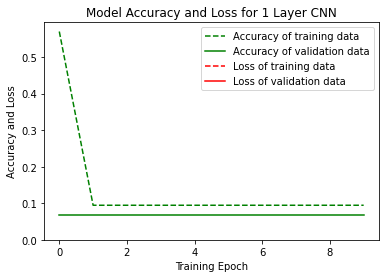

In [19]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss for 1 Layer CNN')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

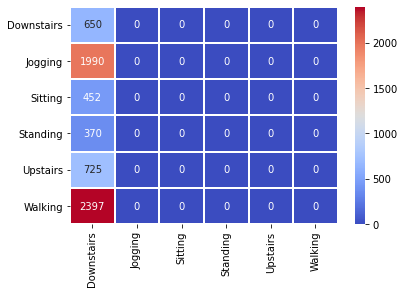

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_predict = model.predict(x_test)
max_y_pred_test = np.argmax(y_predict, axis=1)
max_y_test = np.argmax(y_test, axis=1)
matrix = confusion_matrix(max_y_test, max_y_pred_test)
# show_confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(num_classes, 4))
sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
plt.show()

# Model 2 - 2 Convolution layer and 1 Dense Layer

In [21]:
model = Sequential()
model.add(Conv1D(64,3,activation='relu',input_shape=(no_timeStamp_in_row,no_features)))
model.add(Conv1D(64,3,activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(no_output,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 78, 64)            640       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 76, 64)            12352     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 38, 64)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2432)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 14598     
Total params: 27,590
Trainable params: 27,590
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(x_train,y_train,epochs=10,verbose=1,validation_split=0.2,)

Train on 16694 samples, validate on 4174 samples
Epoch 1/10
16694/16694 [==============================] - 3s 167us/step - loss: nan - accuracy: 0.4356 - val_loss: nan - val_accuracy: 0.0688
Epoch 2/10
16694/16694 [==============================] - 3s 159us/step - loss: nan - accuracy: 0.0945 - val_loss: nan - val_accuracy: 0.0688
Epoch 3/10
16694/16694 [==============================] - 3s 160us/step - loss: nan - accuracy: 0.0945 - val_loss: nan - val_accuracy: 0.0688
Epoch 4/10
16694/16694 [==============================] - 3s 153us/step - loss: nan - accuracy: 0.0945 - val_loss: nan - val_accuracy: 0.0688
Epoch 5/10
16694/16694 [==============================] - 3s 155us/step - loss: nan - accuracy: 0.0945 - val_loss: nan - val_accuracy: 0.0688
Epoch 6/10
16694/16694 [==============================] - 3s 160us/step - loss: nan - accuracy: 0.0945 - val_loss: nan - val_accuracy: 0.0688
Epoch 7/10
16694/16694 [==============================] - 3s 153us/step - loss: nan - accuracy: 0.0

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


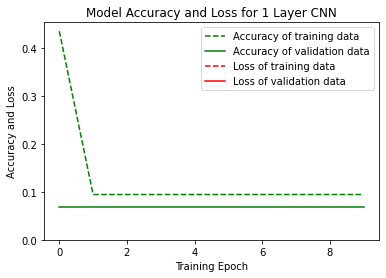

In [23]:
history.history
print(history.history.keys())
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss for 1 Layer CNN')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

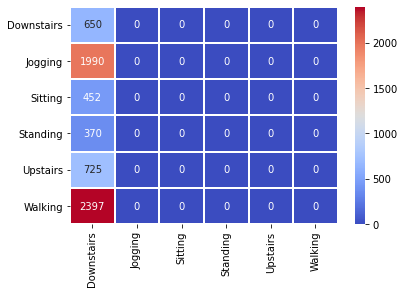

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_predict = model.predict(x_test)
max_y_pred_test = np.argmax(y_predict, axis=1)
max_y_test = np.argmax(y_test, axis=1)
matrix = confusion_matrix(max_y_test, max_y_pred_test)
# show_confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(num_classes, 4))
sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
plt.show()

# Model 3 - 1 C 2 N

In [128]:
model = Sequential()
model.add(Conv1D(64,3,activation='relu',input_shape=(no_timeStamp_in_row,no_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64,activation='softmax'))
model.add(Dense(no_output,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
history = model.fit(x_train,y_train,epochs=10,batch_size=20)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 78, 64)            640       
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 39, 64)            0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 2496)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                159808    
_________________________________________________________________
dense_21 (Dense)             (None, 6)                 390       
Total params: 160,838
Trainable params: 160,838
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
20868/20868 [==============================] - 3s 148us/step - loss: nanTA: 2s - lo - ETA: 1s - loss: 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


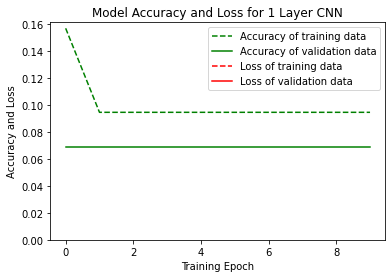

In [42]:
history.history
print(history.history.keys())
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss for 1 Layer CNN')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_predict = model.predict(x_test)
max_y_pred_test = np.argmax(y_predict, axis=1)
max_y_test = np.argmax(y_test, axis=1)
matrix = confusion_matrix(max_y_test, max_y_pred_test)
# show_confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(num_classes, 4))
sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
plt.show()

NameError: name 'LABELS' is not defined

<Figure size 432x288 with 0 Axes>

In [44]:
model = Sequential()
model.add(Conv1D(64,3,activation='relu',input_shape=(no_timeStamp_in_row,no_features)))
model.add(Conv1D(64,3,activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64,activation='softmax'))
model.add(Dense(no_output,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model.fit(x_train,y_train,epochs=10,verbose=1,validation_split=0.2)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 78, 64)            640       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 76, 64)            12352     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 38, 64)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 2432)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                155712    
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 390       
Total params: 169,094
Trainable params: 169,094
Non-trainable params: 0
_______________________________________________

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


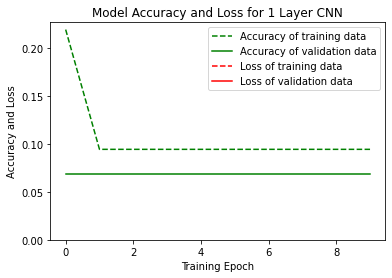

In [45]:
history.history
print(history.history.keys())
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss for 1 Layer CNN')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

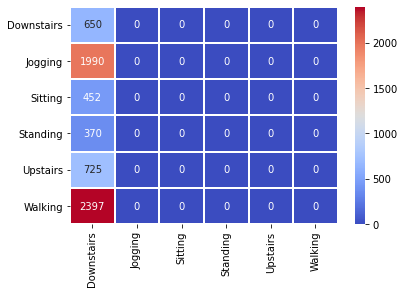

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_predict = model.predict(x_test)
max_y_pred_test = np.argmax(y_predict, axis=1)
max_y_test = np.argmax(y_test, axis=1)
matrix = confusion_matrix(max_y_test, max_y_pred_test)
plt.figure(figsize=(num_classes, 4))
sns.heatmap(matrix,cmap="coolwarm",linecolor='white',linewidths=1,xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt="d")
plt.show()

In [54]:
from keras.layers import Dropout , GlobalMaxPooling1D
model = Sequential()
model.add(Conv1D(160, 12, input_shape=(x_train.shape[1],x_train.shape[2]) , activation='relu'))
model.add(Conv1D(128, 10, activation='relu'))
model.add(Conv1D(96, 8, activation='relu'))
model.add(Conv1D(64, 6, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='softmax'))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
history = model.fit(x_train,y_train,epochs=10,verbose=1)

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 69, 160)           5920      
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 60, 128)           204928    
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 53, 96)            98400     
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 48, 64)            36928     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 64)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 6)               

KeyboardInterrupt: 

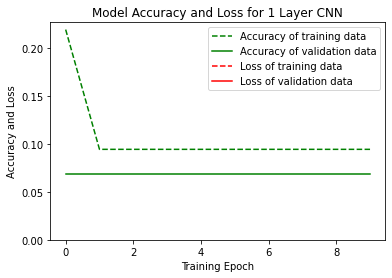

In [51]:
def plot_training_graph(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], "g--", label="Accuracy of training data")
    plt.plot(history.history['val_accuracy'], "g", label="Accuracy of validation data")
    plt.plot(history.history['loss'], "r--", label="Loss of training data")
    plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
    plt.title('Model Accuracy and Loss for 1 Layer CNN')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
plot_training_graph(history)

In [ ]:
def plot_confustion_mat(y_predict,y_test,LABELS,num_classes):
    max_y_pred_test = np.argmax(y_predict, axis=1)
    max_y_test = np.argmax(y_test, axis=1)
    matrix = confusion_matrix(max_y_test, max_y_pred_test)
    # show_confusion_matrix(max_y_test, max_y_pred_test)
    plt.figure(figsize=(num_classes, 4))
    sns.heatmap(matrix,
                    cmap="coolwarm",
                    linecolor='white',
                    linewidths=1,
                    xticklabels=LABELS,
                    yticklabels=LABELS,
                    annot=True,
                    fmt="d")
    plt.show()

y_predict = model.predict(x_test)
plot_confustion_mat(y_predict,y_test,LABELS,num_classes)

In [ ]:
model = Sequential()
model.add(Conv1D(64, 3, input_shape=(x_train.shape[1],x_train.shape[2]) , activation='relu'))
model.add(Conv1D(64, 3 , activation='relu'))
model.add(Conv1D(128, 10, activation='relu'))
model.add(Conv1D(96, 8, activation='relu'))
model.add(Conv1D(64, 6, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(x_train, y_train_one_hot, validation_split=0.3, epochs=150, batch_size=1024)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
y_pred = model.predict_classes(x_test)
tmp = y_test.argmax(axis=-1)
# Creates a confusion matrix
cm = confusion_matrix(tmp, y_pred) 
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,index=['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'], columns = ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking'])
plt.figure(figsize=(10,10))
sns.heatmap(cm_df, annot=True, fmt="d", linewidths=0.5, cmap='Blues', cbar=False, annot_kws={'size':14}, square=True)
plt.title('Kernel \nAccuracy:{0:.3f}'.format(accuracy_score(tmp, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [55]:
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

# redefine model to output right after the first hidden layer
ixs = [0, 1, 2, 3, 4, 5, 6]
outputs = [model.layers[i].output for i in ixs]
model_view = Model(inputs=model.inputs, outputs=outputs)
# get feature map for first hidden layer
model_view.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42_input (InputLayer) (None, 80, 3)             0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 69, 160)           5920      
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 60, 128)           204928    
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 53, 96)            98400     
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 48, 64)            36928     
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 64)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0   

In [56]:
feature_maps = model_view.predict(x_test)

In [59]:
help(Conv1D)

Help on class Conv1D in module keras.layers.convolutional:

class Conv1D(_Conv)
 |  Conv1D(filters, kernel_size, strides=1, padding='valid', data_format='channels_last', dilation_rate=1, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None, **kwargs)
 |  
 |  1D convolution layer (e.g. temporal convolution).
 |  
 |  This layer creates a convolution kernel that is convolved
 |  with the layer input over a single spatial (or temporal) dimension
 |  to produce a tensor of outputs.
 |  If `use_bias` is True, a bias vector is created and added to the outputs.
 |  Finally, if `activation` is not `None`,
 |  it is applied to the outputs as well.
 |  
 |  When using this layer as the first layer in a model,
 |  provide an `input_shape` argument (tuple of integers or `None`, does not
 |  include the batch axis), e.g. `input_shape=(10,

In [63]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(no_output, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(x_train, y_train, epochs=10, batch_size=32, verbose=0)
# evaluate model
_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

NameError: name 'testX' is not defined